# RcTorch NuerIPS submission
## 1st order  Linear ODE's

In [1]:
#import packages
import numpy as np
from numpy import loadtxt
import pylab as pl
from IPython import display
from RcTorchPrivate import *
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import time
import matplotlib.gridspec as gridspec

#this method will ensure that the notebook can use multiprocessing (train multiple 
#RC's in parallel) on jupyterhub or any other linux based system.
try:
    mp.set_start_method("spawn")
except:
    pass
torch.set_default_tensor_type(torch.FloatTensor)
%matplotlib inline
start_time = time.time()

In [2]:
lineW = 3
lineBoxW=2

font = {'size'   : 24}

plt.rc('font', **font)
plt.rcParams['text.usetex'] = True

### This notebook contains the solutions to the linear first order explicitily time-dependent equation   of the form $\dot y + q(t) y = f(t) $.

Specifically we solve three related differential equations:
1) Simple population:  <font color='blue'>$\dot y + y =0$  </font>
* Analytical solution: <font color='green'>$y = y_0 e^{-t}$</font>

2) Driven population:  <font color='blue'>$\dot y + y + \sin(t) =0$ </font>
* Analytical solution: <font color='green'>$y = e^{-t}\left(y_0 + \frac{1}{2}\right) + \frac{1}{2}\left( \sin(t) - \cos(t) \right)$ </font>

3) Driven population with nonlinear time dependence:  <font color='blue'> $\dot y + t^2 y + \sin(t) =0$  </font>
* Analytical solution: None

## helper functions

In [3]:
def plot_predictions(RC, results, integrator_model, ax = None):
    """plots a RC prediction and integrator model prediction for comparison
    Parameters
    ----------
    RC: RcTorchPrivate.esn
        the RcTorch echostate network to evaluate. This model should already have been fit.
    results: dictionary
        the dictionary of results returned by the RC after fitting
    integrator model: function
        the model to be passed to odeint which is a gold standard integrator numerical method
        for solving ODE's written in Fortran. You may find the documentation here:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
    ax: matplotlib.axes._subplots.AxesSubplot
        If provided, the function will plot on this subplot axes
    """
    X = RC.X.cpu()
    if not ax:
        fig, ax = plt.subplots(1,1, figsize = (6,6))
    for i, y in enumerate(results["ys"]):
        y = y.cpu()
        if not i:
            labels = ["RC", "Integrator Solution"]
        else:
            labels = [None, None]
        ax.plot(X, y, color = "blue", label = labels[0], linewidth = lineW + 1, alpha = 0.9)

        #calculate the integrator prediction:
        int_sol = odeint(integrator_model, y0s[i], np.array(X.cpu().squeeze()))
        int_sol = torch.tensor(int_sol)
        
        #plot the integrator prediction
        ax.plot(X, int_sol, '--', color = "red", alpha = 0.9, label = labels[1],  linewidth = lineW)
    
    plt.ylabel(r'$y(t)$');
    ax.legend();
    ax.tick_params(labelbottom=False)
    plt.tight_layout()

def plot_rmsr(RC, results, force, ax = None):
    """plots the residuals of a RC prediction directly from the loss function
    Parameters
    ----------
    RC: RcTorchPrivate.esn
        the RcTorch echostate network to evaluate. This model should already have been fit.
    results: dictionary
        the dictionary of results returned by the RC after fitting
    force: function
        the force function describing the force term in the population equation
    ax: matplotlib.axes._subplots.AxesSubplot
        If provided, the function will plot on this subplot axes
    """
    if not ax:
        fig, ax = plt.subplots(1,1, figsize = (10, 4))
    X = RC.X.cpu()
    ys, ydots = results["ys"], results["ydots"]
    
    residuals = []
    for i, y in enumerate(ys):
        ydot = ydots[i]
        y = y.cpu()
        ydot = ydot.cpu()
        resids = custom_loss(X, y, ydot, None, 
                             force = force, 
                             ode_coefs = RC.ode_coefs,
                             mean = False)
        if not i:
            resids_tensor = resids
            label = r'{Individual Trajectory RMSR}'
        else:
            resids_tensor = torch.cat((resids_tensor, resids), axis = 1)
            label = None
        resids_specific_rmsr = torch.sqrt(resids/1) 
            
        ax.plot(X, resids_specific_rmsr, color = "red", alpha = 0.4, label = label)
        residuals.append(resids)
    
    mean_resid = torch.mean(resids_tensor, axis =1)
    rmsr = torch.sqrt(mean_resid)
    ax.plot(X, rmsr, 
               color = "blue", 
               alpha = 0.9, 
               label = r'{RMSR}')

    ax.legend(prop={"size":16});
    
    ax.set_xlabel(r'$t$')
    ax.set_yscale("log")
    ax.set_ylabel(r'{RMSR}')

def driven_force(X, A = 1):
    return A * torch.sin(X)

def no_force(X, A = 0):
    return A

#define a reparameterization function, empirically we find that g= 1-e^(-t) works well)
def reparam(t, order = 1):
    
    exp_t = torch.exp(-t)
    derivatives_of_g = []
    
    g = 1 - exp_t
    g_dot = 1 - g
    return g, g_dot
    
    #first derivative
    
    
    #example code for higher derivatives:
    #####################################
    
    #derivatives_of_g.append(g_dot)
    #derivatives_of_g.append(g)
#     for i in range(order):
#         if i %2 == 0:
#             #print("even")
#             derivatives_of_g.append(g_dot)
#         else:
#             #print("odd")
#             derivatives_of_g.append(-g_dot)
#    return derivatives_of_g


#simple population eq loss
def custom_loss(X, y, ydot, out_weights, 
                enet_strength = None,
                enet_alpha = None,
                ode_coefs = None,
                force = None, 
                reg = True, 
                reparam = reparam, 
                init_conds = None,
                mean = True):
    
    #converts the nonlinear dependence for t**2
    if ode_coefs[0] == "t**2" or ode_coefs[0] == "t^2":
        ode_coefs[0]  = X ** 2
    
    #lam is short for lambda
    lam = ode_coefs[0]
    L =  ydot + lam * y - force(X)
    
    L = torch.square(L)
    
    if mean:
        L = torch.mean(L)
    
    return L



In [4]:
BURN_IN = 1000
x0,xf, nsteps = 0, 5, 1000
xtrain = torch.linspace(x0, xf, steps = nsteps, requires_grad=False)

#the length of xtrain won't matter above. Only dt , x0, and xf matter for ODEs.
#the reason for this is that the input time vector is reconstructed internally in rctorch
#in order to satisfy the specified dt.
xtrain = torch.linspace(x0, xf, steps = nsteps, requires_grad=False).view(-1,1)

In [5]:
# simple_pop_hps = {'dt': 0.0031622776601683794,
#                   'n_nodes': 250,
#                   'connectivity': 0.3100864962793182,
#                   'spectral_radius': 1.4005038738250732,
#                   'regularization': 10.422439189648184,
#                   'leaking_rate': 0.14719310402870178,
#                   'bias': 0.2954297661781311}

simple_pop_hps = {'dt': 0.0031622776601683794,
 'n_nodes': 250,
 'connectivity': 0.7170604557008349,
 'spectral_radius': 1.5755887031555176,
 'regularization': 0.00034441529823729916,
 'leaking_rate': 0.9272222518920898,
 'bias': 0.1780446171760559}

### declare the initial conditions (each initial condition corresponds to a different curve)


In [6]:
y0s = np.arange(-2, 2.1, 0.5)

#### Train the RC:

In [7]:
%%time

pop_RC = EchoStateNetwork(**simple_pop_hps,
                          random_state = 209, 
                          dtype = torch.float32)

train_args = {"X" : xtrain.view(-1,1),        
              "burn_in" : int(BURN_IN), 
              "ODE_order" : 1,   
              "force" : no_force, 
              "reparam_f" : reparam,
              "ode_coefs" : [1,1]}


results = pop_RC.fit(init_conditions = [y0s,1],
                     train_score = True, 
                     ODE_criterion = custom_loss,
                     **train_args)

CPU times: user 1.18 s, sys: 391 ms, total: 1.57 s
Wall time: 773 ms


#### Declare integrator model

In [8]:
#integrator model
def population_model(y, t, t_pow = 0, force_k = 0, k = 1):
    dydt = -k * y *t**t_pow + force_k*np.sin(t)
    return dydt

#### Plot the integrator solutions vs the RC and the RMSR (directly calculated from the loss function)

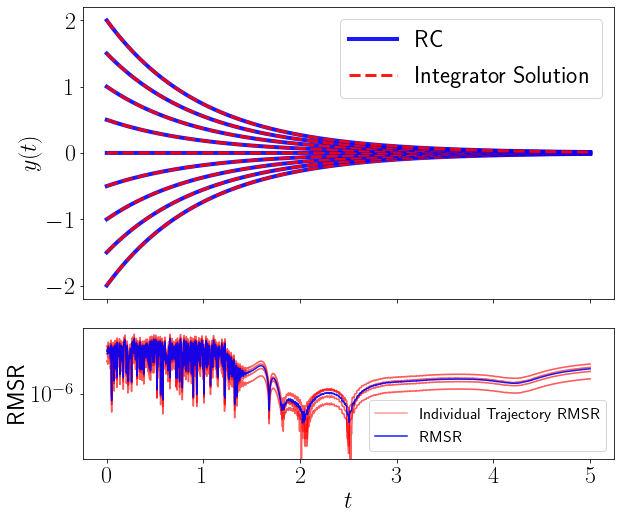

In [9]:
#show results:
fig = plt.figure(figsize = (9,7)); gs1 = gridspec.GridSpec(3, 3);
ax = plt.subplot(gs1[:-1, :])

plot_predictions(pop_RC, results, population_model, ax = ax)

ax = plt.subplot(gs1[-1, :])
plot_data = plot_rmsr(pop_RC, 
                          results, 
                          force = no_force, 
                          ax = ax)

# Driven population

#### declare the initial conditions (each initial condition corresponds to a different curve)


In [10]:
y0s = np.arange(-2, 2.1, 0.5)

#### Train the RC

In [11]:
%%time

driven_pop_hps = {'dt': 0.0031622776601683794,
                  'n_nodes': 500,
                  'connectivity': 0.7875262340500385,
                  'spectral_radius': 9.97140121459961,
                  'regularization': 8.656278081920211,
                  'leaking_rate': 0.007868987508118153,
                  'bias': -0.2435922622680664}

driven_RC = EchoStateNetwork(**driven_pop_hps,
                             random_state = 209,
                             dtype = torch.float32)

train_args = {"X" : xtrain.view(-1,1),        
              "burn_in" : int(BURN_IN), 
              "ODE_order" : 1,   
              "force" : driven_force, 
              "reparam_f" : reparam,
              "ode_coefs" : [1,1]}

results = driven_RC.fit(init_conditions = [y0s,1],#[y0s,1],
                 **train_args, 
                 SOLVE = True,
                 train_score = True, 
                 ODE_criterion = custom_loss)

CPU times: user 2.64 s, sys: 812 ms, total: 3.45 s
Wall time: 1.49 s


#### Declare integrator model

In [12]:
def driven_pop_model(y, t, t_pow = 0, force_k = 1):
    k = 1
    dydt = -k * y *t**t_pow + force_k*np.sin(t)
    return dydt

#### Plot the integrator solutions vs the RC and the RMSR (directly calculated from the loss function)

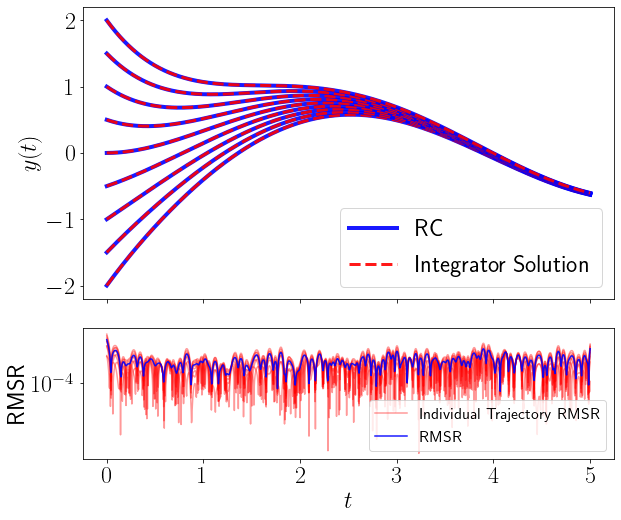

In [13]:
fig = plt.figure(figsize = (9, 7)); gs1 = gridspec.GridSpec(3, 3);
ax = plt.subplot(gs1[:-1, :])


plot_predictions(RC = driven_RC, 
                 results = results, 
                 integrator_model = driven_pop_model, 
                 ax = ax)
ax = plt.subplot(gs1[-1, :])
plot_rmsr(RC = driven_RC, 
          results = results, 
          force = driven_force, 
          ax = ax)

# Driven population with nonlinear time dependence (t^2)

#### declare the initial conditions (each initial condition corresponds to a different curve)


In [14]:
y0s = np.arange(-2, 2.1, 0.5)

#### Train the RC

In [15]:
%%time
t2_hps =  {'n_nodes': 500,
           'connectivity': 0.09905712745750006,
           'spectral_radius': 1.8904799222946167,
           'regularization': 714.156090350679,
           'leaking_rate': 0.031645022332668304,
           'bias': -0.24167031049728394,
           'dt' : 0.005}

t2_RC = EchoStateNetwork(**t2_hps,
                         random_state = 209, 
                         dtype = torch.float32)

train_args = {"X" : xtrain.view(-1,1),        
              "burn_in" : int(BURN_IN), 
              "ODE_order" : 1,   
              "force" : driven_force, 
              "reparam_f" : reparam,
              "ode_coefs" : ["t**2", 1]}


results = t2_RC.fit(init_conditions = [y0s,1],
                    SOLVE = True,
                    train_score = True, 
                    ODE_criterion = custom_loss,
                    **train_args)

CPU times: user 1.88 s, sys: 524 ms, total: 2.4 s
Wall time: 1.14 s


#### Declare integrator model

In [16]:
def driven_pop_model_t2(y, t, t_pow = 2, force_k = 1):
    k = 1
    dydt = -k * y *t**t_pow + force_k*np.sin(t)
    return dydt

#### Plot the integrator solutions vs the RC and the RMSR (directly calculated from the loss function)

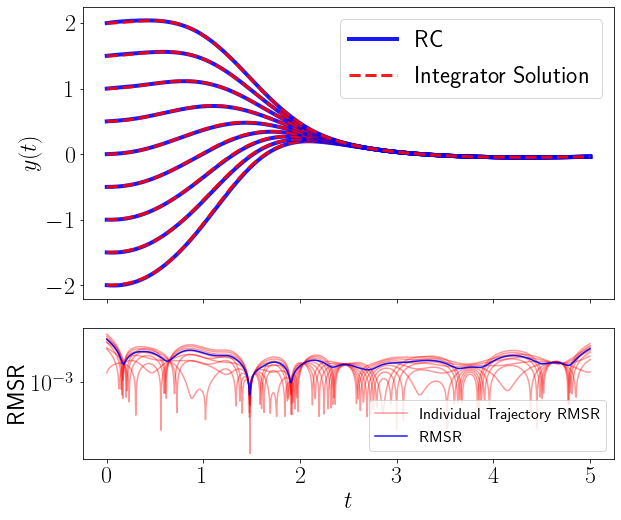

In [17]:
fig = plt.figure(figsize = (9, 7)); gs1 = gridspec.GridSpec(3, 3);
ax = plt.subplot(gs1[:-1, :])

gts = plot_predictions(RC = t2_RC, 
                       results = results, 
                       integrator_model = driven_pop_model_t2, 
                       ax = ax)

ax = plt.subplot(gs1[-1, :])
plot_data = plot_rmsr(t2_RC, 
                      results = results, 
                      force = driven_force, 
                      ax = ax)

In [18]:
end_time = time.time()
print(f'Total notebook runtime: {end_time - start_time:.2f} seconds')

Total notebook runtime: 7.15 seconds
